In [1]:
from os import environ

environ['CUDA_VISIBLE_DEVICES'] = "1"
from sys import path, stdout
import os
from IPython.display import clear_output

path.append("/home/leandrosantos/IC-AutoEncoder/")
path.append("/home/leandrosantos/IC-AutoEncoder/modules/")
path.append("/home/leandrosantos/IC-AutoEncoder/src/modules/")

import tensorflow as tf 

import random as rd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm_notebook

import time
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from modules.misc import ssim_metric
from modules.ImageMetrics.metrics import three_ssim, psnrb

2023-11-11 13:14:24.598467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Fetching dataset

from modules.DataMod import DataSet
import cupy

cifar, tiny, noised_dataset = DataSet(), DataSet(), DataSet()

cifar.load_rafael_cifar_10_noise_data()
tiny.load_rafael_tinyImagenet_64x64_noise_data()
print("Cifar and tiny loaded.")

noised_dataset.load_cifar_and_tiny(cifar, tiny)
noised_dataset.add_gaussian_noise(dist_normal = 0.3) # adds gaussian noise
print("Dataset created.")

cupy.get_default_memory_pool().free_all_blocks()
cupy.get_default_pinned_memory_pool().free_all_blocks()

del cifar, tiny

x_test = noised_dataset.x_test
y_test = noised_dataset.y_test / 255
x_train = noised_dataset.x_train
y_train = noised_dataset.y_train / 255

del noised_dataset

Cifar and tiny loaded.
Dataset created.


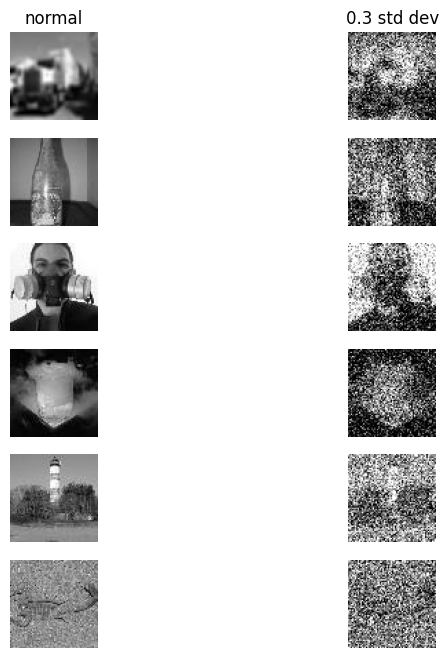

In [3]:
plt.figure(figsize=(8, 8))
columns = 2
rows = 6

magic_number = [rd.randint(0, x_train.shape[0]-1) for x in range(rows)]

plt.subplot(rows, columns, 1)
plt.title("normal")
plt.subplot(rows, columns, 2)
plt.title("0.3 std dev")

for idx in range(rows):
    plt.subplot(rows, columns, columns*idx + 1)
    plt.imshow(y_train[magic_number[idx]], cmap='gray')
    plt.axis("off")
    plt.subplot(rows, columns, columns*idx + 2)
    plt.imshow(x_train[magic_number[idx]], cmap='gray')
    plt.axis("off")

In [4]:
# hyperparameters 

LEARNING_RATE = 0.00005
BATCH_SIZE = 16
IMG_SHAPE = (64, 64, 1)

N_EPOCHS = 500
CURRENT_EPOCH = 0
PATIENCE_LIMIT = 10

ADVERSARIAL_LOSS_FACTOR = 1.0
PIXEL_LOSS_FACTOR = 1.0
SMOOTH_LOSS_FACTOR = 1.0

N_CRITIC = 1
SAVE_EVERY_N_EPOCH = 1

In [5]:
tf.random.set_seed(45)
y_train_batches = tf.random.shuffle(y_train)
tf.random.set_seed(45)
x_train_batches = tf.random.shuffle(x_train)

num_train_batches = int(x_train.shape[0]/BATCH_SIZE)
y_train_batches = np.split(y_train_batches, num_train_batches)
x_train_batches = np.split(x_train_batches, num_train_batches)

val_size = int(len(y_test)*0.8)
tf.random.set_seed(43)
y_test_batches = tf.random.shuffle(y_test[:val_size])
tf.random.set_seed(43)
x_test_batches = tf.random.shuffle(x_test[:val_size])

num_test_batches = int(x_test_batches.shape[0]/500)
y_test_batches = np.split(y_test_batches, num_test_batches)
x_test_batches = np.split(x_test_batches, num_test_batches)

def standard_images(images):
    for image in images:
        image = tf.cast(tf.image.per_image_standardization(image), tf.float64)
    
    return images
    

In [6]:
x_test_batches = np.array(standard_images(x_test_batches))
y_test_batches = np.array(standard_images(y_test_batches))

x_train_batches = np.array(standard_images(x_train_batches))
y_train_batches = np.array(standard_images(y_train_batches))

In [7]:
assert x_test_batches.shape == y_test_batches.shape
assert x_train_batches.shape == y_train_batches.shape

In [8]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Input, Dropout, MaxPooling2D, UpSampling2D, Conv2DTranspose, Add
from tensorflow.keras.activations import sigmoid

In [9]:
def generator_model(input_shape=IMG_SHAPE):

    input_layer = Input(input_shape)

    # First Set
    conv1 = Conv2D(kernel_size=4, filters=32, strides=1, padding="same")(input_layer)
    norm1 = BatchNormalization()(conv1)
    out_conv1 = tf.nn.leaky_relu(norm1)

    conv2 = Conv2D(kernel_size=3, filters=64, strides=1, padding="same")(out_conv1)
    norm2 = BatchNormalization()(conv2)
    out_conv2 = tf.nn.leaky_relu(norm2)

    conv3 = Conv2D(kernel_size=3, filters=128, strides=1, padding="same")(out_conv2)
    norm3 = BatchNormalization()(conv3)
    out_conv3 = tf.nn.leaky_relu(norm3)
    # End of First Set

    # Second Set - Residual
    # Block 1
    res1_conv1 = Conv2D(kernel_size=3, filters=128, strides=1, padding="same")(out_conv3)
    res1_norm1 = BatchNormalization()(res1_conv1)
    out_res1_conv1 = tf.nn.leaky_relu(res1_norm1)

    res1_conv2 = Conv2D(kernel_size=3, filters=128, strides=1, padding="same")(out_res1_conv1)
    res1_norm2 = BatchNormalization()(res1_conv2)
    out_res1_conv2 = tf.nn.leaky_relu(res1_norm2)

    out_res1 = out_res1_conv2 + out_conv3

    # Block 2
    res2_conv1 = Conv2D(kernel_size=3, filters=128, strides=1, padding="same")(out_res1)
    res2_norm1 = BatchNormalization()(res2_conv1)
    out_res2_conv1 = tf.nn.leaky_relu(res2_norm1)

    res2_conv2 = Conv2D(kernel_size=3, filters=128, strides=1, padding="same")(out_res2_conv1)
    res2_norm2 = BatchNormalization()(res2_conv2)
    out_res2_conv2 = tf.nn.leaky_relu(res2_norm2)

    out_res2 = out_res2_conv2 + out_res1

    # Block 3
    res3_conv1 = Conv2D(kernel_size=3, filters=128, strides=1, padding="same")(out_res2)
    res3_norm1 = BatchNormalization()(res3_conv1)
    out_res3_conv1 = tf.nn.leaky_relu(res3_norm1)

    res3_conv2 = Conv2D(kernel_size=3, filters=128, strides=1, padding="same")(out_res3_conv1)
    res3_norm2 = BatchNormalization()(res3_conv2)
    out_res3_conv2 = tf.nn.leaky_relu(res3_norm2)

    out_res3 = out_res3_conv2 + out_res2
    # End of Second Set
    
    # Third Set - Deconvolutional
    deconv1 = Conv2D(kernel_size=3, filters=64, strides=1, padding="same")(out_res3)
    deconv1_norm1 = BatchNormalization()(deconv1)
    out_deconv1 = tf.nn.leaky_relu(deconv1_norm1)

    deconv2 = Conv2D(kernel_size=3, filters=32, strides=1, padding="same")(out_deconv1)
    deconv2_norm1 = BatchNormalization()(deconv2)
    out_deconv2 = tf.nn.leaky_relu(deconv2_norm1)
    
    out_deconv2_temp = out_deconv2 + conv1

    deconv3 = Conv2D(kernel_size=4, filters=IMG_SHAPE[-1], strides=1, padding="same")(out_deconv2_temp)
    deconv3_norm1 = BatchNormalization()(deconv3)
    out_deconv3 = tf.nn.tanh(deconv3_norm1)

    out_deconv3_temp = out_deconv3 + input_layer
    # End of Third Set
    
    output =  tf.clip_by_value(out_deconv3_temp, 0, 1)

    return Model(inputs=input_layer, outputs=output)

def discriminator_model(input_x_shape=IMG_SHAPE):
    input_layer = Input(input_x_shape)

    conv1 = Conv2D(kernel_size=3, filters=48, strides=2, padding="same")(input_layer)
    norm1 = BatchNormalization()(conv1)
    out_conv1 = tf.nn.leaky_relu(norm1)

    conv2 = Conv2D(kernel_size=3, filters=96, strides=2, padding="same")(out_conv1)
    norm2 = BatchNormalization()(conv2)
    out_conv2 = tf.nn.leaky_relu(norm2)
    out_conv2 = Dropout(0.2)(out_conv2)
    
    conv3 = Conv2D(kernel_size=3, filters=192, strides=2, padding="same")(out_conv2)
    norm3 = BatchNormalization()(conv3)
    out_conv3 = tf.nn.leaky_relu(norm3)

    conv4 = Conv2D(kernel_size=3, filters=384, strides=2, padding="same")(out_conv3)
    norm4 = BatchNormalization()(conv4)
    out_conv4 = tf.nn.leaky_relu(norm4)
    out_conv4 = Dropout(0.2)(out_conv4)
    
    conv5 = Conv2D(kernel_size=3, filters=1, strides=2, padding="same")(out_conv4)
    norm5 = BatchNormalization()(conv5)
    out_conv5 = sigmoid(norm5)
    
    return Model(inputs=input_layer, outputs=out_conv5)

In [10]:
generator = generator_model()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   544         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 tf.nn.leaky_relu (TFOpLambda)  (None, 64, 64, 32)   0           ['batch_normalization[0][0]']

In [11]:
discriminator = discriminator_model()

discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 48)        480       
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 48)       192       
 chNormalization)                                                
                                                                 
 tf.nn.leaky_relu_11 (TFOpLa  (None, 32, 32, 48)       0         
 mbda)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 96)        41568     
                                                                 
 batch_normalization_13 (Bat  (None, 16, 16, 96)       384 

In [12]:
MODEL_NAME = 'GAN'

OUTPUT_PATH = os.path.join('outputs', MODEL_NAME)
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", MODEL_NAME, 'train_data') # Sets up a log directory.
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)

In [13]:
from tensorflow.keras.optimizers import Adam


D_optimizer = Adam(learning_rate=LEARNING_RATE)
G_optimizer = Adam(learning_rate=LEARNING_RATE)


cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def get_smooth_loss(image):
    batch_count = tf.shape(image)[0]
    image_height = tf.shape(image)[1]
    image_width = tf.shape(image)[2]

    horizontal_normal = tf.slice(image, [0, 0, 0,0], [batch_count, image_height, image_width-1,IMG_SHAPE[-1]])
    horizontal_one_right = tf.slice(image, [0, 0, 1,0], [batch_count, image_height, image_width-1,IMG_SHAPE[-1]])
    vertical_normal = tf.slice(image, [0, 0, 0,0], [batch_count, image_height-1, image_width,IMG_SHAPE[-1]])
    vertical_one_right = tf.slice(image, [0, 1, 0,0], [batch_count, image_height-1, image_width,IMG_SHAPE[-1]])
    smooth_loss = tf.nn.l2_loss(horizontal_normal-horizontal_one_right)+tf.nn.l2_loss(vertical_normal-vertical_one_right)
    return smooth_loss

def get_pixel_loss(target,prediction):
    pixel_difference = target - prediction
    pixel_loss = tf.nn.l2_loss(pixel_difference)
    return pixel_loss

@tf.function
def G_train_step(noised_images, real_images):
    with tf.GradientTape() as gp_tape:
        generated_image = tf.cast(generator([noised_images], training=True), tf.float64)
        generated_image_pred = tf.cast(discriminator([generated_image], training=True), tf.float64)

        g_loss = ADVERSARIAL_LOSS_FACTOR * -tf.reduce_mean(tf.math.log(generated_image_pred)) \
        + PIXEL_LOSS_FACTOR * get_pixel_loss(real_images, generated_image) \
        + SMOOTH_LOSS_FACTOR * get_smooth_loss(generated_image) \
        #+ tf.cast(SSIM_LOSS_FACTOR * tf.math.reduce_mean(1-ssim_metric(real_images, generated_image, max_val=1.0)), tf.float64)
        #+ CROSS_ENTROPY_LOSS_FACTOR * cross_entropy(tf.ones_like(generated_image_pred), generated_image_pred)

    G_gradients = gp_tape.gradient(g_loss, generator.trainable_variables)
    G_optimizer.apply_gradients(zip(G_gradients, generator.trainable_variables))
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('G_loss', g_loss, step=step)
            
    return g_loss

@tf.function
def D_train_step(noised_images, real_images):
    with tf.GradientTape() as gp_tape:
        generated_image = tf.cast(generator([noised_images], training=True), tf.float64)
        generated_image_pred = tf.cast(discriminator([generated_image], training=True), tf.float64)
        real_image_pred = tf.cast(discriminator([real_images], training=True), tf.float64)

        d_loss = -tf.reduce_mean(tf.math.log(real_image_pred) + tf.math.log(1.-generated_image_pred)) \
        #+ cross_entropy(tf.ones_like(generated_image_pred), generated_image_pred) \
        #+ cross_entropy(tf.ones_like(real_image_pred), real_image_pred)
        
    D_gradients = gp_tape.gradient(d_loss, discriminator.trainable_variables)
    D_optimizer.apply_gradients(zip(D_gradients, discriminator.trainable_variables))
    
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('D_loss', tf.reduce_mean(d_loss), step=step)
    
    return d_loss

In [14]:
def generate_and_save_images(model, epoch, test_input, expected_output, figure_size=(12,6), subplot=(3,6), save=True, show=False):
    '''
        Generate images and plot it.
    '''
    rows = subplot[0]
    columns = subplot[1]

    predictions = model(test_input, training=False) 
    fig, axs = plt.subplots(rows, columns, figsize=figure_size, gridspec_kw={'width_ratios':[1 for x in range(columns)], 'height_ratios':[1 for x in range(rows)]})
    fig.subplots_adjust(top=0.4)
    
    for row in range(rows):
        for column in range(columns):
            i = column
            if row == 0:
                # y
                axs[row, column].set_title('GroundTruth') if i == columns//2 else None
                axs[row, column].imshow(expected_output[i], cmap='gray')
            elif row == 1:
                # predict
                axs[row, column].set_title('Output') if i == columns//2 else None
                axs[row, column].imshow(predictions[i], cmap='gray')
            else:
                # x
                axs[row, column].set_title('Input') if i == columns//2 else None
                axs[row, column].imshow(test_input[i], cmap='gray')
            axs[row, column].axis('off')
    
    ssim_out = tf.math.reduce_mean(ssim_metric(expected_output, predictions, max_val=1.))
    #psnrb_v_out = tf.math.reduce_mean(psnrb(expected_output, predictions))
    
    ssim_in = tf.math.reduce_mean(ssim_metric(expected_output, test_input, max_val=1.))
    #psnrb_v_out = tf.math.reduce_mean(psnrb(expected_output, predictions))
    fig.tight_layout()
    fig.suptitle("ssim_input:%.5f, ssim_output: %.5f" %(ssim_in, ssim_out), y=1)
            
    del fig, axs
    if save:
        plt.savefig(os.path.join(OUTPUT_PATH, 'image_at_epoch_{:04d}.png'.format(epoch)))
    if show:
        plt.show()
    plt.close()

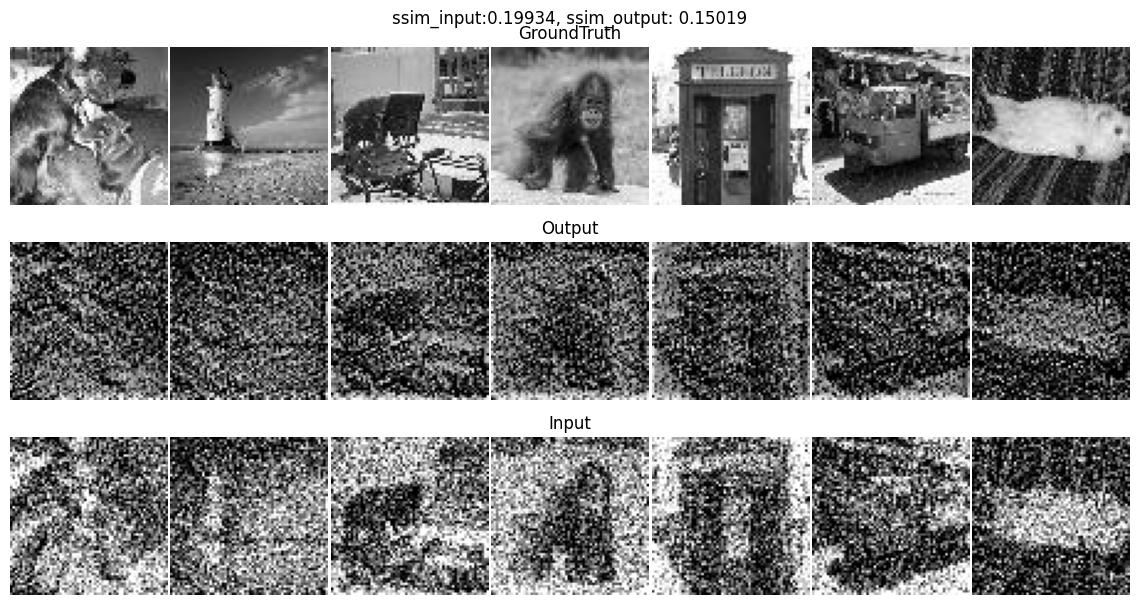

In [15]:
num_examples_to_generate = 7

# change y_test for x_test
magic_number = [rd.randint(0, x_test[val_size:].shape[0]-1) for x in range(num_examples_to_generate)]

sample = np.array([x_test[val_size:][idx] for idx in magic_number])
answer = np.array([y_test[val_size:][idx] for idx in magic_number])

generate_and_save_images(generator, 0, sample, answer, figure_size=(12,6), subplot=(3, num_examples_to_generate), save=False, show=True)

In [16]:
checkpoint_path = os.path.join("checkpoints", "tensorflow", MODEL_NAME)

ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           G_optimizer=G_optimizer,
                           D_optimizer=D_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[1])
    CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

Latest checkpoint of epoch 101 restored!!


In [ ]:
n_critic_count = 0
D_loss = float('inf')
G_loss = float('inf')

best_val_metric = 0
patience = 0

# train until saturate
epoch = CURRENT_EPOCH
while epoch < N_EPOCHS+1:
    with tqdm_notebook(total=len(y_train_batches)) as pbar:
        for step, (training_batch, groundtruth_batch) in enumerate(zip(x_train_batches, y_train_batches)):
            D_loss = D_train_step(training_batch, groundtruth_batch)
            n_critic_count+=1
            
            if n_critic_count >= N_CRITIC:
                G_loss = G_train_step(training_batch, groundtruth_batch)
                n_critic_cout = 0
            
            images_out = generator(training_batch, training=False)
            ssim_train_metric = tf.math.reduce_mean(ssim_metric(groundtruth_batch, images_out, max_val=1.))
            pbar.set_description_str("Epoch %d/%d: " %(epoch+1, N_EPOCHS))
            pbar.set_postfix_str("G_loss: %.5f, D_loss: %.5f, ssim_metric: %.5f" %(G_loss, D_loss, ssim_train_metric))
            pbar.update(1)
            #clear_output(wait=True)
        
        # validação
        ssim = []
        psnrb_v = []
        for (x, y) in zip(x_test_batches, y_test_batches):
            images_out = generator(x, training=False)

            ssim.append(tf.math.reduce_mean(ssim_metric(y, images_out, max_val=1.)))
            #psnrb_v.append(tf.math.reduce_mean(psnrb(y, images_out)))
            
        with file_writer.as_default():
            #tf.summary.scalar('psnrb_val', tf.reduce_mean(psnrb_v), step=step)
            tf.summary.scalar('ssim_val', tf.reduce_mean(ssim), step=step)
        
        pbar.set_postfix_str("G_loss_train: %.5f, D_loss_train: %.5f, ssim_metric_train: %.5f, ssim_metric_val: %.5f" %(G_loss, D_loss, ssim_train_metric, tf.reduce_mean(ssim)))
        
        if epoch % SAVE_EVERY_N_EPOCH == 0:
            # only save se improved
            ckpt_save_path = ckpt_manager.save()
            generate_and_save_images(generator, epoch, sample, answer, figure_size=(12,6), subplot=(3,num_examples_to_generate), save=True)

    if tf.reduce_mean(ssim) >= best_val_metric:
        patience = 0
        best_val_metric = tf.reduce_mean(ssim)
    else:
        patience += 1

    if patience == PATIENCE_LIMIT:
        break
    epoch+=1 

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [17]:
ssim = []
psnrb_v = []
for (x, y) in zip(np.split(x_test[val_size:], 20), np.split(y_test[val_size:], 20)):
    images_out = generator(x, training=False)

    ssim.append(tf.math.reduce_mean(ssim_metric(y, images_out, max_val=1.)))
    psnrb_v.append(tf.math.reduce_mean(psnrb(y, images_out)))

In [18]:
tf.reduce_mean(psnrb_v)

<tf.Tensor: shape=(), dtype=float64, numpy=67.21786877542726>

In [19]:
tf.reduce_mean(ssim)

<tf.Tensor: shape=(), dtype=float32, numpy=0.45781094>

In [23]:
%tensorboard --logdir logs/tensorflow/

In [22]:
%load_ext tensorboard